In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [61]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test) %>% (kaggle.house$na$fixAll)

dataset <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    select(SalePrice, OverallQual, Neighborhood, GrLivArea) %>%
    filter(GrLivArea < 4e3) 

dataset %>% head

SalePrice,OverallQual,Neighborhood,GrLivArea
208500,7,CollgCr,1710
181500,6,Veenker,1262
223500,7,CollgCr,1786
140000,7,Crawfor,1717
250000,8,NoRidge,2198
143000,5,Mitchel,1362


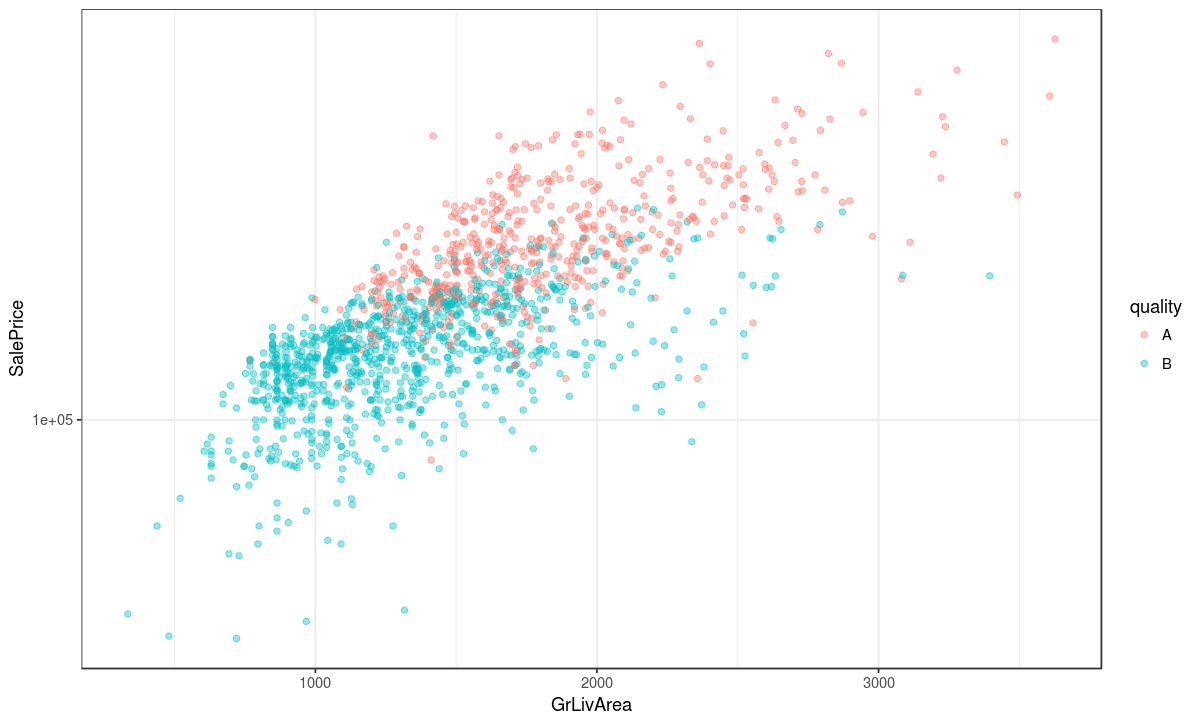

In [62]:
options(repr.plot.width = 10, repr.plot.height = 6)

combine.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4, 5, 6) ~ 'B',
            TRUE ~ 'A'
        )
    )
}

combine.Neighborhood <- function (df) {
    df %>%
    group_by(Neighborhood) %>%
    mutate(
        hood.avg.sale.price = median(SalePrice),
        hood.level = case_when(
            hood.avg.sale.price < 160e3 ~ '2',
            TRUE ~ '1'
        )
    )
}

dataset %>%
    (combine.OverallQual) %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=quality), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

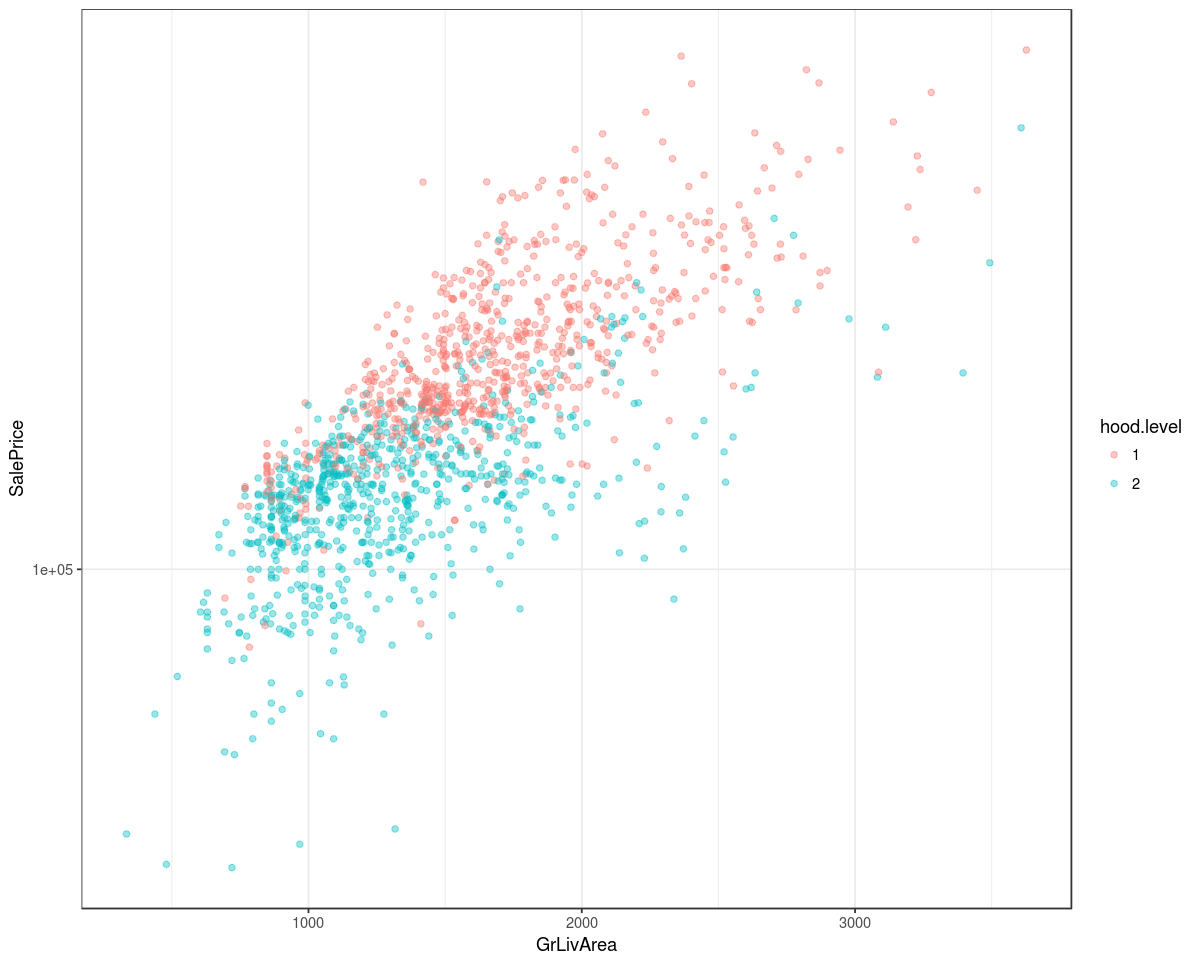

In [63]:
options(repr.plot.width = 10, repr.plot.height = 8)

df.Neighborhood <- 
    dataset %>%
    select(Neighborhood, SalePrice, GrLivArea) %>%
    (combine.Neighborhood)

df.Neighborhood %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=hood.level), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

hood.level,Neighborhood,n,mi,ma,check,n.hood.level,ncum,id
2,MeadowV,17,88000,88000,TRUE,723,17,1
2,IDOTRR,37,103000,103000,TRUE,723,54,2
2,BrDale,16,106000,106000,TRUE,723,70,3
2,OldTown,113,119000,119000,TRUE,723,183,4
2,Edwards,98,119500,119500,TRUE,723,281,5
2,BrkSide,58,124300,124300,TRUE,723,339,6
2,Sawyer,74,135000,135000,TRUE,723,413,7
2,Blueste,2,137500,137500,TRUE,723,415,8
2,SWISU,25,139500,139500,TRUE,723,440,9
2,NAmes,225,140000,140000,TRUE,723,665,10


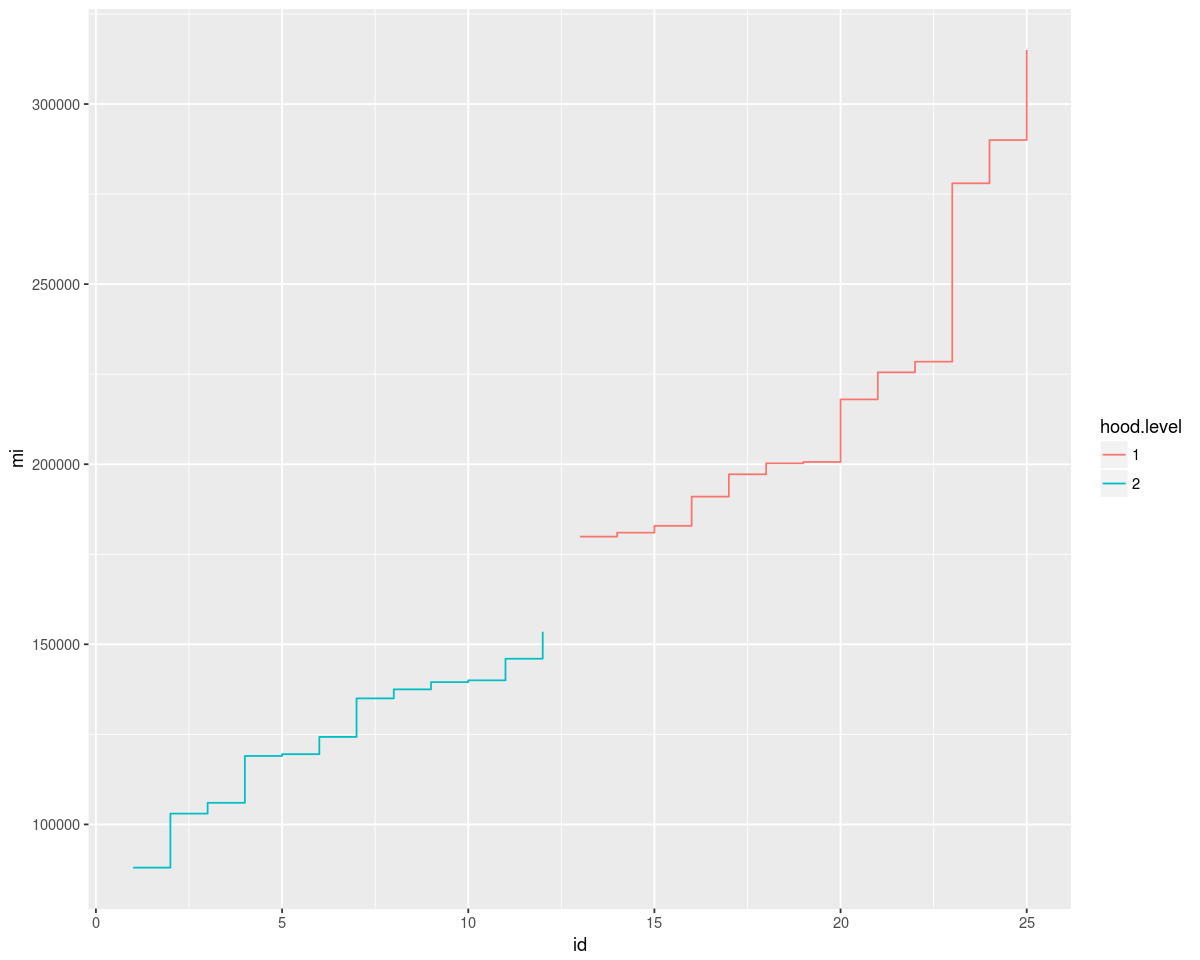

In [64]:
tmp <- df.Neighborhood %>%
    group_by(hood.level, Neighborhood) %>%
    summarise(
        n = n(),
        mi = min(hood.avg.sale.price),
        ma = max(hood.avg.sale.price),
        check = mi == ma
    ) %>%
    mutate(
        n.hood.level = sum(n)
    ) %>%
    arrange(mi) %>%
    ungroup %>%
    mutate(
        ncum = cumsum(n),
        id = row_number()
    )

tmp

tmp %>%
    ggplot() +
    geom_step(aes(id, mi, color=hood.level))

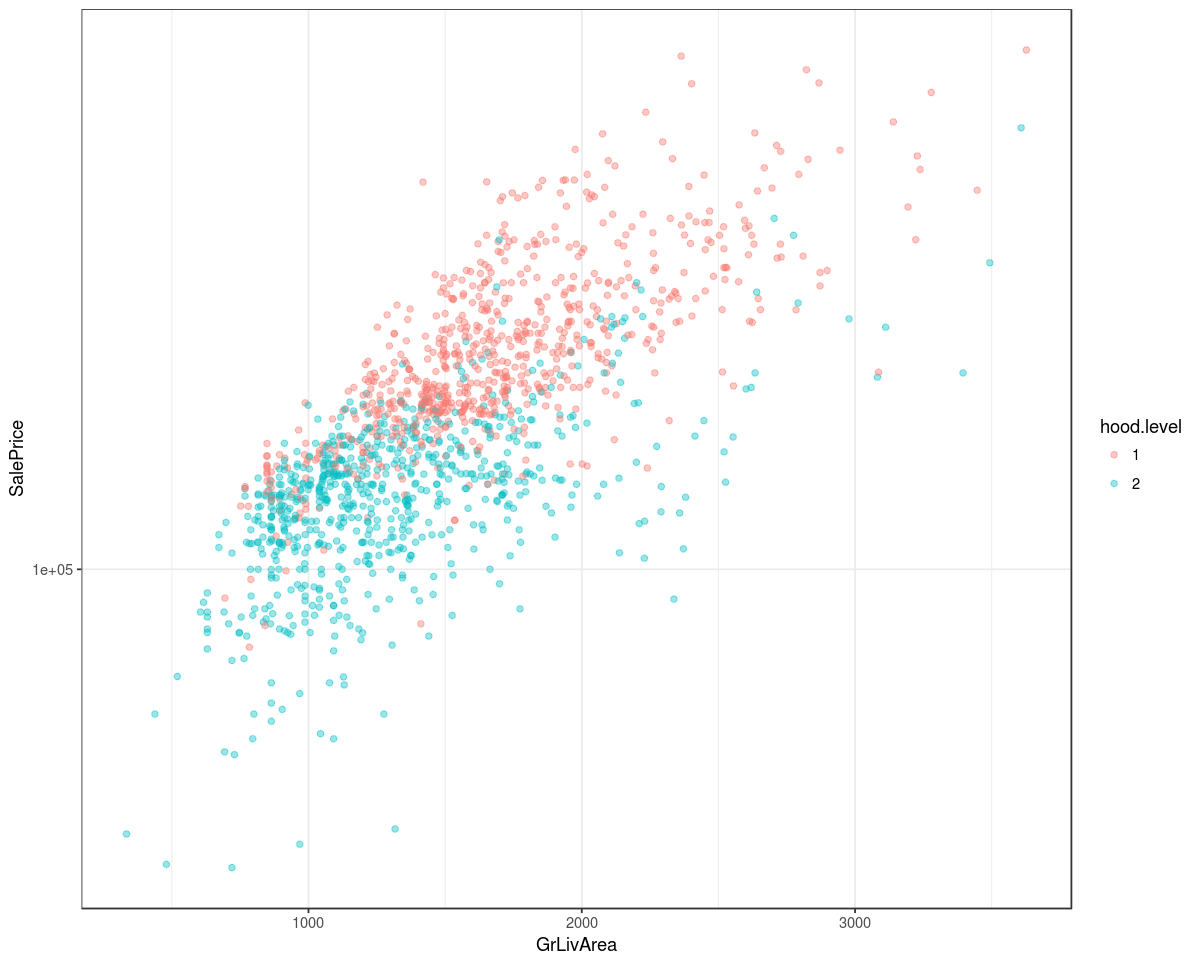

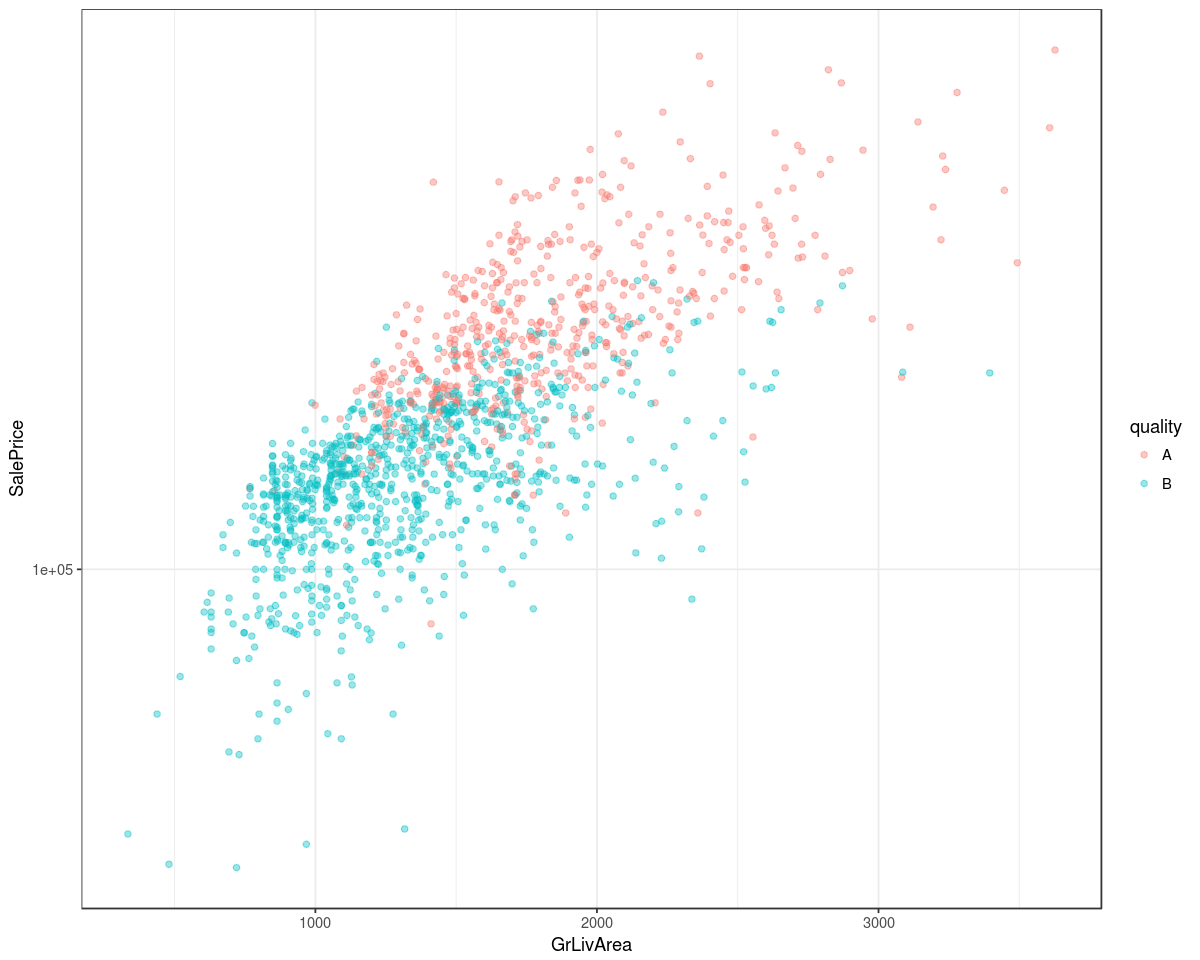

In [65]:
options(repr.plot.width = 10, repr.plot.height = 8)

df.final <- dataset %>%
    (combine.OverallQual) %>%
    (combine.Neighborhood) %>%
    ungroup %>%
    select(SalePrice, quality, hood.level, GrLivArea)

df.final %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=hood.level), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

df.final %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=quality), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

In [66]:
df.final %>%
    group_by(hood.level, quality) %>%
    summarise(
        avg.price.per.sqfeat = median(SalePrice / GrLivArea),
        n = n()
    ) %>%
    arrange(hood.level, desc(quality))

hood.level,quality,avg.price.per.sqfeat,n
1,B,120.0810,247
1,A,134.7870,486
2,B,107.3961,665
2,A,102.1607,58


In [90]:
ds <- 
    df.final %>%
    mutate(avg.price = mean(SalePrice)) %>%
    group_by(quality) %>%
    mutate(
        qual.avg.price = mean(SalePrice),
        qual.avg.price.diff = qual.avg.price - first(avg.price)
    ) %>%
    group_by(hood.level) %>%
    mutate(
        hood.avg.price = mean(SalePrice),
        hood.avg.price.diff = hood.avg.price - first(avg.price)
    )

ds %>% head

SalePrice,quality,hood.level,GrLivArea,avg.price,qual.avg.price,qual.avg.price.diff,hood.avg.price,hood.avg.price.diff
208500,A,1,1710,180151.2,246819.9,66668.64,225540.7,45389.43
181500,B,1,1262,180151.2,140384.0,-39767.26,225540.7,45389.43
223500,A,1,1786,180151.2,246819.9,66668.64,225540.7,45389.43
140000,A,1,1717,180151.2,246819.9,66668.64,225540.7,45389.43
250000,A,1,2198,180151.2,246819.9,66668.64,225540.7,45389.43
143000,B,2,1362,180151.2,140384.0,-39767.26,134134.0,-46017.22


In [89]:
ds %>% group_by(quality) %>% summarise(min(qual.avg.price), max(qual.avg.price))

mod1 = lm(SalePrice ~ quality, data=ds)
glance(mod1)
tidy(mod1)

mod2 = lm(SalePrice ~ qual.avg.price, data=ds)
glance(mod2)
tidy(mod2)

mod2a = lm(SalePrice ~ qual.avg.price.diff, data=ds)
glance(mod2a)
tidy(mod2a)

quality,min(qual.avg.price),max(qual.avg.price)
A,246819.9,246819.9
B,140384.0,140384.0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.4510176,0.45064,56846.61,1194.537,1.419417e-191,2,-18005.42,36016.85,36032.7,4.698655e+12,1454


term,estimate,std.error,statistic,p.value
(Intercept),246819.9,2437.278,101.26864,0.000000e+00
qualityB,-106435.9,3079.558,-34.56207,1.419417e-191


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.4510176,0.45064,56846.61,1194.537,1.419417e-191,2,-18005.42,36016.85,36032.7,4.698655e+12,1454


term,estimate,std.error,statistic,p.value
(Intercept),-5.613675e-10,5.421121e+03,-1.035519e-13,1.000000e+00
qual.avg.price,1.000000e+00,2.893345e-02,3.456207e+01,1.419417e-191


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.4510176,0.45064,56846.61,1194.537,1.419417e-191,2,-18005.42,36016.85,36032.7,4.698655e+12,1454


term,estimate,std.error,statistic,p.value
(Intercept),180151.2,1.489786e+03,120.92423,0.000000e+00
qual.avg.price.diff,1.0,2.893345e-02,34.56207,1.419417e-191


In [82]:
ds %>% 
group_by(quality, hood.level) %>%
summarise(
    avg.price = mean(SalePrice),
    qual.avg.price = mean(qual.avg.price),
    hood.avg.price = mean(hood.avg.price)
)

mod3 = lm(SalePrice ~ quality+hood.level, data=ds)
glance(mod3)
tidy(mod3)

quality,hood.level,avg.price,qual.avg.price,hood.avg.price
A,1,253046.8,246819.9,225540.7
A,2,194642.5,246819.9,134134.0
B,1,171419.3,140384.0,225540.7
B,2,128856.6,140384.0,134134.0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5086099,0.5079335,53800.7,751.9587,6.626546e-225,3,-17924.74,35857.48,35878.62,4.205731e+12,1453


term,estimate,std.error,statistic,p.value
(Intercept),251735.17,2337.236,107.70635,0.000000e+00
qualityB,-77735.10,3651.260,-21.28994,9.228324e-88
hood.level2,-46102.07,3532.796,-13.04974,6.916709e-37


In [86]:
ds %>% 
group_by(quality, hood.level) %>%
summarise(
    avg.price = mean(SalePrice),
    qual.avg.price = mean(qual.avg.price),
    hood.avg.price = mean(hood.avg.price)
)

mod4 = lm(SalePrice ~ qual.avg.price+hood.avg.price, data=ds)
glance(mod4)
tidy(mod4)

-4.228310e+04 + 7.303466e-01*246819.9 + 5.043623e-01*225540.7
-4.228310e+04 + 7.303466e-01*246819.9 + 5.043623e-01*134134.0
-4.228310e+04 + 7.303466e-01*140384.0 + 5.043623e-01*225540.7
-4.228310e+04 + 7.303466e-01*140384.0 + 5.043623e-01*134134.0

quality,hood.level,avg.price,qual.avg.price,hood.avg.price
A,1,253046.8,246819.9,225540.7
A,2,194642.5,246819.9,134134.0
B,1,171419.3,140384.0,225540.7
B,2,128856.6,140384.0,134134.0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5086099,0.5079335,53800.7,751.9587,6.626546e-225,3,-17924.74,35857.48,35878.62,4.205731e+12,1453


term,estimate,std.error,statistic,p.value
(Intercept),-4.228310e+04,6.068125e+03,-6.968067,4.856810e-12
qual.avg.price,7.303466e-01,3.430478e-02,21.289935,9.228324e-88
hood.avg.price,5.043623e-01,3.864922e-02,13.049740,6.916709e-37


[1] 251735.2

[1] 205633.1

[1] 174000.1

[1] 127898

In [97]:
ds %>% 
group_by(quality, hood.level) %>%
summarise(
    qual.hood.avg.price = mean(SalePrice),
    qual.avg.price.diff = mean(qual.avg.price.diff),
    hood.avg.price.diff = mean(hood.avg.price.diff),
    avg.price = mean(avg.price)
)

mod4 = lm(SalePrice ~ qual.avg.price.diff+hood.avg.price.diff, data=ds)
glance(mod4)
tidy(mod4)

1.801512e+05 + 7.303466e-01*66668.64 + 5.043623e-01*45389.43
1.801512e+05 + 7.303466e-01*66668.64 + 5.043623e-01*(-46017.22)
1.801512e+05 + 7.303466e-01*(-39767.26) + 5.043623e-01*45389.43
1.801512e+05 + 7.303466e-01*(-39767.26) + 5.043623e-01*(-46017.22)

quality,hood.level,qual.hood.avg.price,qual.avg.price.diff,hood.avg.price.diff,avg.price
A,1,253046.8,66668.64,45389.43,180151.2
A,2,194642.5,66668.64,-46017.22,180151.2
B,1,171419.3,-39767.26,45389.43,180151.2
B,2,128856.6,-39767.26,-46017.22,180151.2


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5086099,0.5079335,53800.7,751.9587,6.626546e-225,3,-17924.74,35857.48,35878.62,4.205731e+12,1453


term,estimate,std.error,statistic,p.value
(Intercept),1.801512e+05,1.409962e+03,127.77031,0.000000e+00
qual.avg.price.diff,7.303466e-01,3.430478e-02,21.28994,9.228324e-88
hood.avg.price.diff,5.043623e-01,3.864922e-02,13.04974,6.916709e-37


[1] 251735.1

[1] 205633.1

[1] 174000

[1] 127898